In [119]:
import json
import numpy as np
from pathlib import Path
import pickle as pkl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [120]:
os.chdir('..')

In [126]:
with open('results (2).json', 'r') as f:
    obj2 = json.load(f)
    
with open('results (1).json', 'r') as f:
    obj1 = json.load(f)
    
obj = obj1 | obj2
    
with open('results_misc (1).pkl', 'rb') as f:
    obj_misc1 = pkl.load(f)
    
with open('results_misc (2).pkl', 'rb') as f:
    obj_misc2 = pkl.load(f)
    
obj_misc = obj_misc1 | obj_misc2

In [127]:
obj.keys()

dict_keys(['liar-ernie-masked', 'liar-ernie-unmasked'])

In [128]:
obj_misc.keys()

dict_keys(['liar-ernie-unmasked', 'liar-ernie-masked'])

In [153]:
org_scores_l = []
adv_scores_l = []
new_tokens_l = []
source_l = []
n_obs = []

for config in obj.keys():
    org_scores = np.array(obj[config]['orig_pred'])
    adv_scores = np.array(obj[config]['adv_pred'])
    replacements = obj[config]['replacements']
    
    has_person_idx = np.array(list(map(lambda x: x[0] != 'NOT EXIST', replacements)))
    org_scores = org_scores[has_person_idx]
    adv_scores = adv_scores[has_person_idx]
    replacements = list(filter(lambda x: x[0] != 'NOT EXIST', replacements))
    new_tokens = list(map(lambda x: x[1], replacements))
    source = np.repeat(np.array([config]), org_scores.shape[0])
    
    org_scores_l.append(org_scores)
    adv_scores_l.append(adv_scores)
    new_tokens_l.append(new_tokens)
    source_l.append(source)
    n_obs.append(np.arange(len(source)))
    
org_scores = np.concatenate(org_scores_l)
adv_scores = np.concatenate(adv_scores_l)
new_tokens = np.concatenate(new_tokens_l)
source = np.concatenate(source_l)
n_obs = np.concatenate(n_obs)

data = [el.split('-')[0] for el in source]
model = [el.split('-')[1] for el in source]
mode = [el.split('-')[2] for el in source]

df = pd.DataFrame({
    'org_score': org_scores,
    'adv_score': adv_scores,
    'new_token': new_tokens,
    'data': data,
    'model': model,
    'mode': mode,
    'n_obs': n_obs
})

df['success'] = (org_scores > 0.5).astype(int) != (adv_scores > 0.5).astype(int)

In [154]:
dfs = []
for key, item in obj_misc.items():
    ratios = obj_misc[key]['ratios']
    ratios = np.array(ratios)[~np.isnan(ratios)]
    df_temp = pd.DataFrame({'ratio': ratios})
    df_temp['data'] = key.split('-')[0]
    df_temp['model'] = key.split('-')[1]
    df_temp['mode'] = key.split('-')[2]
    
    dfs.append(pd.DataFrame(df_temp))
    
df_misc = pd.concat(dfs)

## Vizualizations

In [161]:
liar.iloc[54]['text']

'Says Milken Institute rated San Antonio as nations top-performing local economy.'

In [158]:
df[df['new_token'] == 'obama']

,org_score,adv_score,new_token,data,model,mode,n_obs,success
30,0.592518,0.592518,obama,liar,ernie,masked,30,False
54,0.608941,0.608941,obama,liar,ernie,masked,54,False
63,0.515201,0.515201,obama,liar,ernie,masked,63,False
67,0.568840,0.568840,obama,liar,ernie,masked,67,False
82,0.627252,0.627252,obama,liar,ernie,masked,82,False
88,0.573746,0.573746,obama,liar,ernie,masked,88,False
98,0.624905,0.624905,obama,liar,ernie,masked,98,False
100,0.517034,0.517034,obama,liar,ernie,masked,100,False
113,0.587061,0.587061,obama,liar,ernie,masked,113,False
122,0.656934,0.656934,obama,liar,ernie,masked,122,False


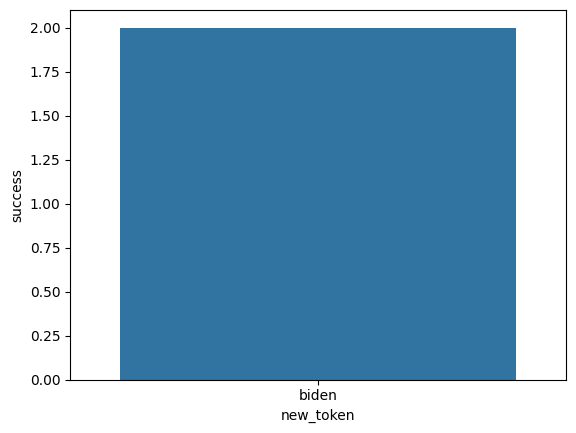

In [132]:
n = len(df['data'].unique())

fig, ax = plt.subplots(ncols=n)

for idx, data_name in enumerate(df['data'].unique()):
    df_temp = df[(df['data'] == data_name) & (df['success'] == True) & (df['mode'] == 'unmasked')]
    df_temp = df_temp.groupby('new_token').count().reset_index()
    
    sns.barplot(data=df_temp, x='new_token', y='success')

<Axes: xlabel='data', ylabel='success'>

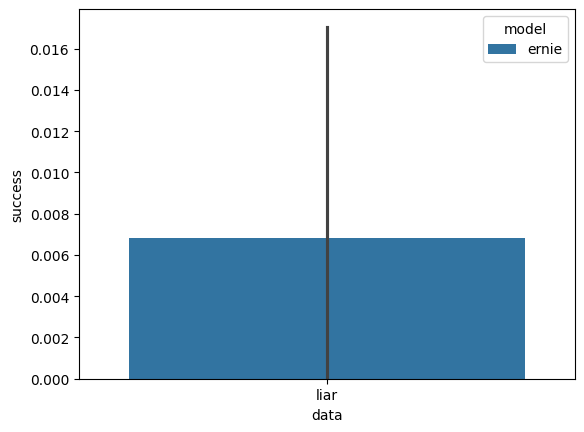

In [139]:
temp_df = df[df['mode'] == 'unmasked']
sns.barplot(data=temp_df, x='data', y='success', hue='model')

In [137]:
temp_df = df[df['mode'] == 'unmasked']
temp_df.groupby(['data', 'model'])['success'].mean()

data  model
liar  ernie    0.006826
Name: success, dtype: float64

<Axes: xlabel='data', ylabel='ratio'>

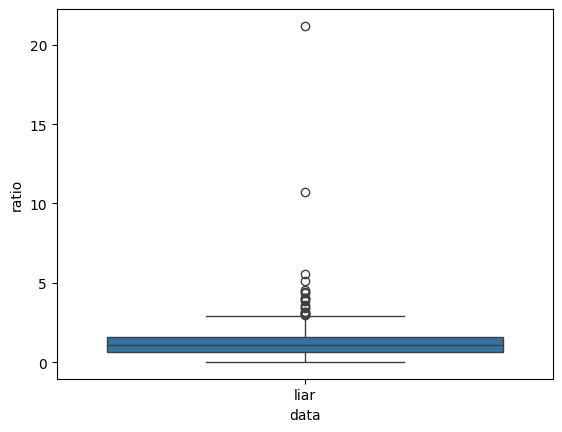

In [141]:
temp_df = df_misc[(df_misc['mode'] == 'unmasked') & (df_misc['model'] == 'ernie')]
sns.boxplot(data=temp_df, x='data', y='ratio')

## Examples

In [163]:
biggest_changes_idx = np.argsort(-np.abs(org_scores - adv_scores))[:20]
df.iloc[biggest_changes_idx]

,org_score,adv_score,new_token,data,model,mode,n_obs,success
579,0.180446,0.804549,biden,liar,ernie,unmasked,286,True
419,0.391880,0.950809,biden,liar,ernie,unmasked,126,True
478,0.636580,0.970525,steve,liar,ernie,unmasked,185,False
432,0.419801,0.164081,romney,liar,ernie,unmasked,139,False
382,0.681834,0.855284,warren,liar,ernie,unmasked,89,False
286,0.167200,0.316550,marta,liar,ernie,masked,286,False
454,0.383995,0.238848,romney,liar,ernie,unmasked,161,False
126,0.457560,0.567331,austin,liar,ernie,masked,126,True
564,0.132691,0.223378,earl,liar,ernie,unmasked,271,False
4,0.655550,0.745723,walker,liar,ernie,masked,4,False


In [121]:
coaid = pd.read_csv(Path("data", 'coaid', "test.csv"), header=0)
liar = pd.read_csv(Path("data", 'liar', "test.csv"), header=0)
isot = pd.read_csv(Path("data", 'isot', "test.csv"), header=0)

In [164]:
liar.iloc[286]['text']

'Dark money spending in the 2016 election cycle is 10 times what it was at the same point in the 2012 election cycle, when it topped $308 million.'